## Worked example of GWR (Python)

This notebook mirrors the structure and analyses from `tutorial_GWR.Rmd`, translating them into Python with GeoPandas, Statsmodels, scikit-gstat, and MGWR.

### Goal
- Estimate spatially varying relationships (GWR) of corn yield to N and seeding rates.
- Use the tidied spatial dataset stored as a GeoPackage.

### Dataset
- GeoPackage: `Field05.gpkg`
- Path: `/Users/emine2/Documents/CLASSES/01_2024-FALL/CPSC-444_SpatialAnalysis/Module_4-5/Module 4.5 Data & Slides/GWR Case study/Field05.gpkg`

You can download the data file and upload here- if `wget` command doesn't work below

[https://github.com/acesillinois/cpsc444-F2025/blob/main/datasets/Field05.gpkg](https://)

### Requirements
Install packages if needed (uncomment and run in a terminal or a notebook cell):
```bash
pip install geopandas pyproj shapely rtree statsmodels seaborn matplotlib pandas numpy scikit-gstat mgwr contextily
```




In [ ]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install scikit-gstat mgwr

!wget https://github.com/acesillinois/cpsc444-F2025/raw/refs/heads/main/datasets/Field05.gpkg

--2025-10-22 21:14:09--  https://github.com/acesillinois/cpsc444-F2025/raw/refs/heads/main/datasets/Field05.gpkg
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/acesillinois/cpsc444-F2025/refs/heads/main/datasets/Field05.gpkg [following]
--2025-10-22 21:14:09--  https://raw.githubusercontent.com/acesillinois/cpsc444-F2025/refs/heads/main/datasets/Field05.gpkg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1028096 (1004K) [application/octet-stream]
Saving to: ‘Field05.gpkg.1’

Field05.gpkg.1      100%[===================>]   1004K  --.-KB/s    in 0.03s   

2025-10-22 21:14:09 (31.2 MB/s) - ‘Fiel

In [ ]:
!pip install geopandas pyproj shapely rtree statsmodels seaborn matplotlib pandas numpy scikit-gstat mgwr contextily

In [ ]:
# Imports and setup
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns

# Stats / models
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Variogram
from skgstat import Variogram

# GWR
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW

# Mapping
import contextily as cx

# Plot style
sns.set(style="whitegrid", context="notebook")
plt.rcParams.update({"figure.figsize": (8, 6), "figure.dpi": 120})

# Paths
GPKG_PATH = "Field05.gpkg"

print("GeoPackage path exists:", os.path.exists(GPKG_PATH))

GeoPackage path exists: True


In [ ]:
!ls -al
!

total 2028
drwxr-xr-x 1 root root    4096 Oct 22 21:14 .
drwxr-xr-x 1 root root    4096 Oct 22 20:44 ..
drwxr-xr-x 4 root root    4096 Oct 21 16:51 .config
-rw-r--r-- 1 root root 1028096 Oct 22 20:52 Field05.gpkg
-rw-r--r-- 1 root root 1028096 Oct 22 21:14 Field05.gpkg.1
drwxr-xr-x 2 root root    4096 Oct 22 20:53 .ipynb_checkpoints
drwxr-xr-x 1 root root    4096 Oct 21 16:52 sample_data


In [ ]:
field05 = gpd.read_file("Field05.gpkg")

In [ ]:
# Ensure SRPlanf and NPlanf are categorical (Option A)
from pandas.api.types import is_categorical_dtype

if 'SRPlanf' not in field05.columns:
    field05['SRPlanf'] = field05['SRPlan']
if not is_categorical_dtype(field05['SRPlanf']):
    field05['SRPlanf'] = field05['SRPlanf'].astype('category')

if 'NPlanf' not in field05.columns:
    field05['NPlanf'] = field05['NPlan']
if not is_categorical_dtype(field05['NPlanf']):
    field05['NPlanf'] = field05['NPlanf'].astype('category')

print('SRPlanf dtype:', field05['SRPlanf'].dtype)
print('NPlanf dtype:', field05['NPlanf'].dtype)


SRPlanf dtype: category
NPlanf dtype: category


In [ ]:
# Load data and basic inspection
# Read GeoPackage into a GeoDataFrame
field05 = gpd.read_file(GPKG_PATH)
field05 = field05.to_crs(epsg=32616)  # match projection

# Quick look at structure
display(field05.head())
print("CRS:", field05.crs)
print("Rows, Columns:", field05.shape)

# List columns of interest
cols_interest = [
    "SubID","ID","SRPlan","NPlan","Area","Headland","N_pts","MuKey",
    "ECS","ECS_sd","ECD","ECD_sd","Elev","Elev_sd","Slope","Slope_sd",
    "Curv","Curv_sd","TWI","TWI_sd","TPI","TPI_sd","Yield","Yield_sd",
    "Moisture","Moisture_sd","VI1","VI1_sd","VI2","VI2_sd","VI3","VI3_sd",
    "SRPlan2","NRPlan2","SRPlanf","NPlanf"
]
print("Available columns:", [c for c in cols_interest if c in field05.columns])


,SubID,ID,SRPlan,NPlan,Area,Headland,N_pts,MuKey,ECS_sd,ECS,...,VI1,VI2_sd,VI2,VI3_sd,VI3,SRPlan2,NPlan2,NPlanf,SRPlanf,geometry
0,39,24,31000.0,44.0,1560.298728,No,16,246517,0.546958,20.442388,...,-0.025056,0.005544,-0.078950,0.008520,-0.004986,9.610000e+08,1936.0,44,31k,"POLYGON ((364080.179 4398372.82, 364101.508 43..."
1,40,24,31000.0,44.0,1560.298728,No,15,246517,0.772253,22.111250,...,-0.009737,0.007371,-0.084663,0.006777,0.004405,9.610000e+08,1936.0,44,31k,"POLYGON ((364101.509 4398372.447, 364122.838 4..."
2,41,25,34500.0,38.0,1560.297979,No,15,246544,0.718886,23.301075,...,-0.014970,0.008884,-0.097565,0.005224,-0.001865,1.190250e+09,1444.0,38,34k,"POLYGON ((364122.838 4398372.074, 364144.167 4..."
3,42,25,34500.0,38.0,1560.297979,No,16,246544,0.755857,22.708853,...,-0.039440,0.017035,-0.081638,0.003575,0.003028,1.190250e+09,1444.0,38,34k,"POLYGON ((364144.168 4398371.701, 364165.497 4..."
4,43,25,34500.0,38.0,1560.297979,No,14,246544,0.322303,21.599925,...,-0.098559,0.018276,-0.026506,0.012072,-0.006675,1.190250e+09,1444.0,38,34k,"POLYGON ((364165.497 4398371.328, 364186.826 4..."


CRS: EPSG:32616
Rows, Columns: (832, 41)
Available columns: ['SubID', 'ID', 'SRPlan', 'NPlan', 'Area', 'Headland', 'N_pts', 'MuKey', 'ECS', 'ECS_sd', 'ECD', 'ECD_sd', 'Elev', 'Elev_sd', 'Slope', 'Slope_sd', 'Curv', 'Curv_sd', 'TWI', 'TWI_sd', 'TPI', 'TPI_sd', 'Yield', 'Yield_sd', 'Moisture', 'Moisture_sd', 'VI1', 'VI1_sd', 'VI2', 'VI2_sd', 'VI3', 'VI3_sd', 'SRPlan2', 'SRPlanf', 'NPlanf']


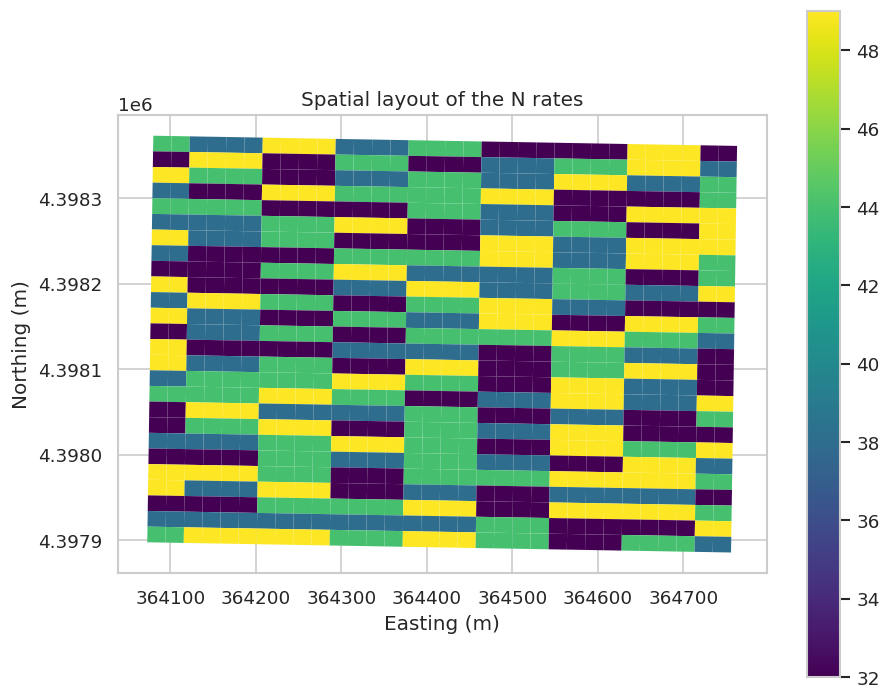

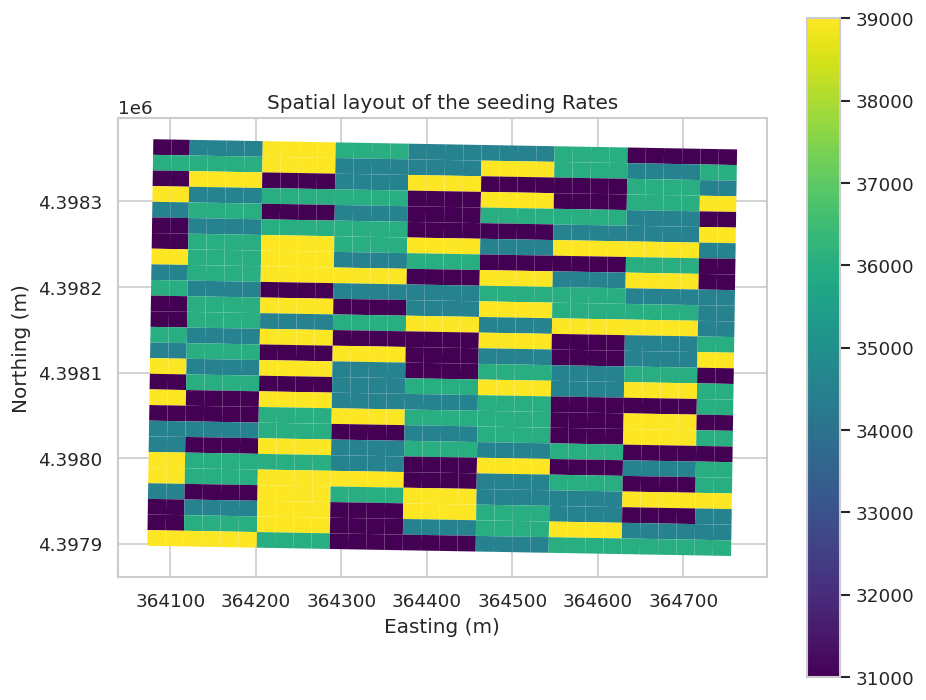

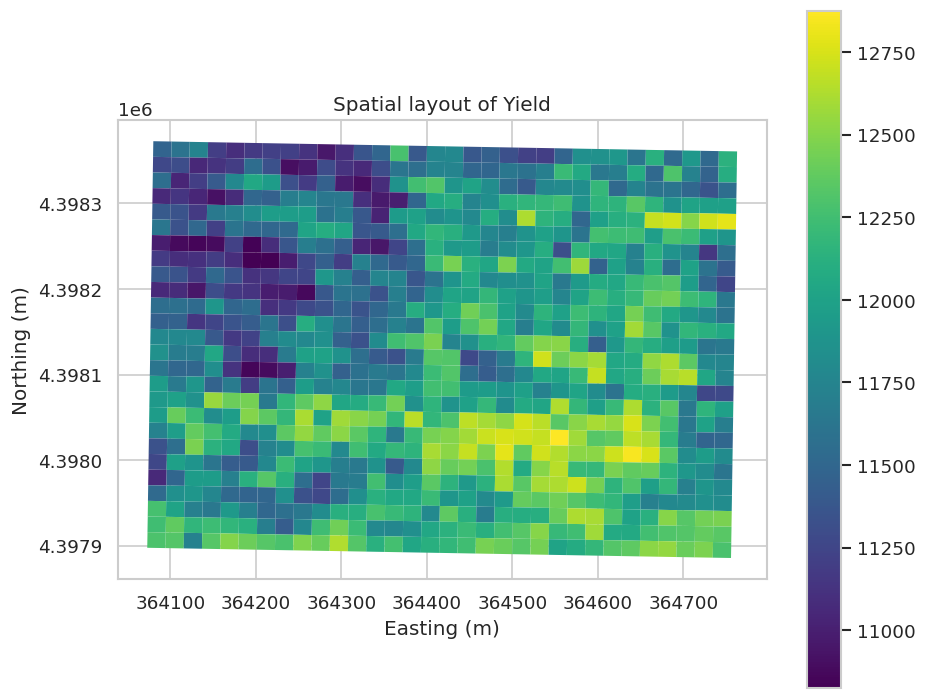

In [ ]:
# Spatial layout maps (NPlan, SRPlan, Yield)
# Helper to plot a choropleth with consistent style

def plot_choropleth(gdf, column, title, cmap="viridis"):
    ax = gdf.plot(column=column, cmap=cmap, edgecolor="none", legend=True)
    ax.set_title(title)
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    plt.tight_layout()
    plt.show()

plot_choropleth(field05, "NPlan", "Spatial layout of the N rates")
plot_choropleth(field05, "SRPlan", "Spatial layout of the seeding Rates")
plot_choropleth(field05, "Yield", "Spatial layout of Yield")


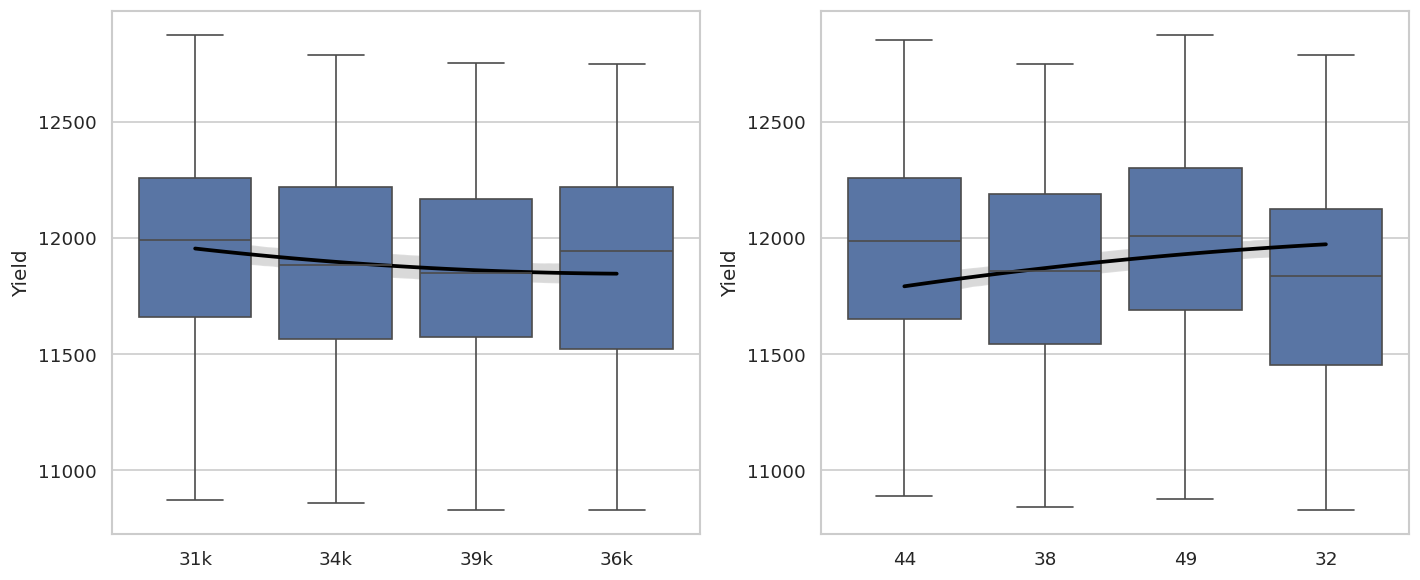

In [ ]:
# Boxplots: Yield vs SRPlanf and Yield vs NPlanf
# Ensure factors exist or derive them from numeric bins if needed
if "SRPlanf" not in field05.columns:
    field05["SRPlanf"] = field05["SRPlan"].astype("category")
if "NPlanf" not in field05.columns:
    field05["NPlanf"] = field05["NPlan"].astype("category")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(data=field05, x="SRPlanf", y="Yield", ax=axes[0])
axes[0].set_xlabel("seeding Rate (seed/ac)")
axes[0].set_ylabel("Yield (kg/ha)")
sns.regplot(x=field05['SRPlanf'].astype('category').cat.codes, y=field05['Yield'], order=2, scatter=False, ax=axes[0], color='black')


sns.boxplot(data=field05, x="NPlanf", y="Yield", ax=axes[1])
axes[1].set_xlabel("N Rate (kg/ha)")
axes[1].set_ylabel("Yield (kg/ha)")
sns.regplot(x=field05['NPlanf'].astype('category').cat.codes, y=field05['Yield'], order=2, scatter=False, ax=axes[1], color='black')
plt.tight_layout()
plt.show()


                            OLS Regression Results                            
Dep. Variable:                  Yield   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     10.60
Date:                Wed, 22 Oct 2025   Prob (F-statistic):           7.63e-07
Time:                        21:15:34   Log-Likelihood:                -6237.9
No. Observations:                 832   AIC:                         1.248e+04
Df Residuals:                     828   BIC:                         1.250e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     9492.8423   1239.842      7.656   

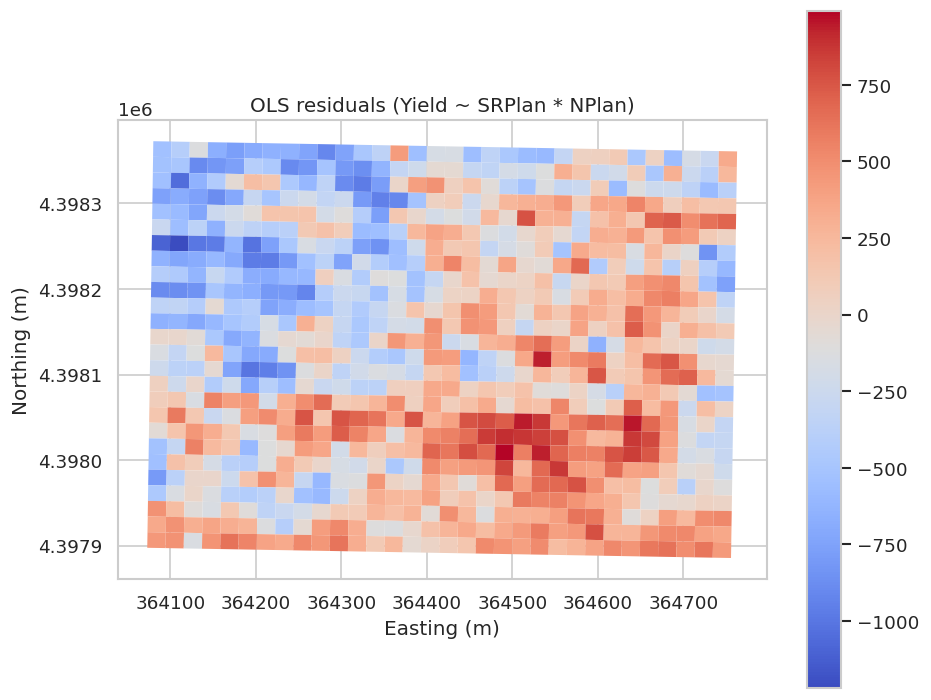

In [ ]:
# Basic linear model: Yield ~ SRPlan * NPlan
# Fit using statsmodels formula API, add residuals to GeoDataFrame
m_lm = ols("Yield ~ SRPlan * NPlan", data=field05).fit()
print(m_lm.summary())

field05["resid"] = m_lm.resid

# Plot residuals choropleth
plot_choropleth(field05, "resid", "OLS residuals (Yield ~ SRPlan * NPlan)", cmap="coolwarm")


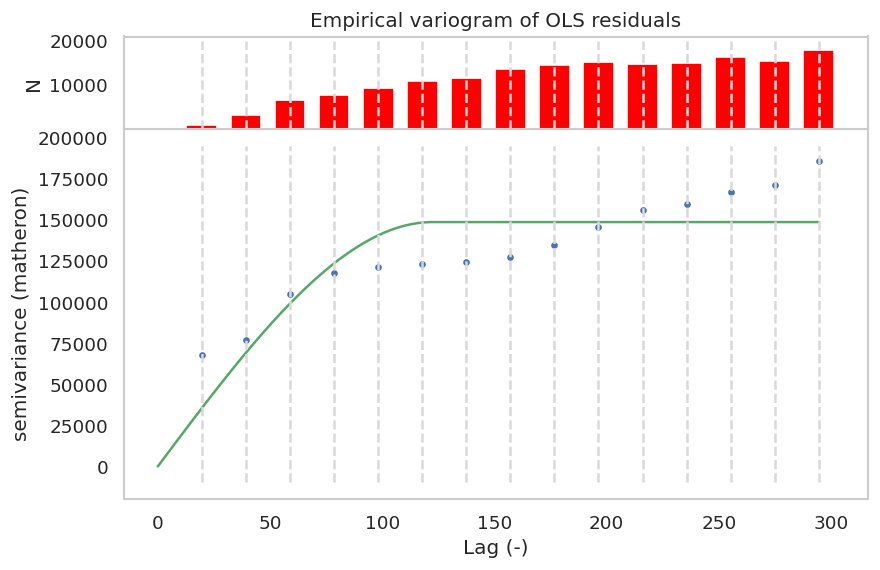

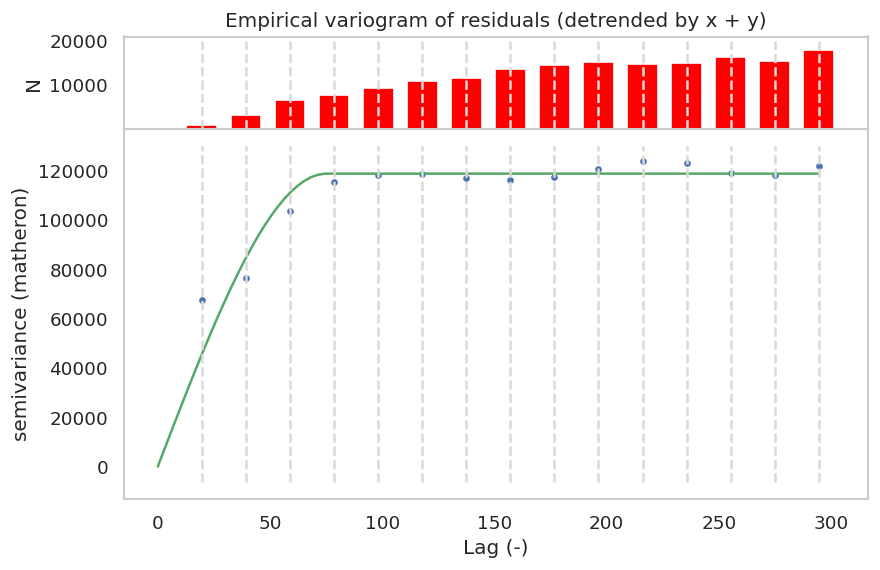

Trend R^2: 0.36411258371476474


In [ ]:
# Variogram of residuals and detrended variogram
# Extract point centroids for polygons for variogram calculations
centroids = field05.geometry.centroid
coords = np.vstack([centroids.x.values, centroids.y.values]).T
residuals = field05["resid"].values

# Empirical variogram
V = Variogram(coords, residuals, normalize=False, n_lags=15, maxlag="median")
fig = V.plot()
plt.title("Empirical variogram of OLS residuals")
plt.show()

# Detrending using linear coordinates (x, y)
X_trend = sm.add_constant(pd.DataFrame({"x": coords[:,0], "y": coords[:,1]}))
trend_model = sm.OLS(residuals, X_trend).fit()
resid_detrended = residuals - trend_model.predict(X_trend)

V_detrended = Variogram(coords, resid_detrended, normalize=False, n_lags=15, maxlag="median")
fig = V_detrended.plot()
plt.title("Empirical variogram of residuals (detrended by x + y)")
plt.show()

print("Trend R^2:", trend_model.rsquared)


In [ ]:
# GWR
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW

# GWR: Yield ~ SRPlan (adaptive bandwidth)
# Prepare coordinates (u, v) and design matrix
centroids = field05.geometry.centroid
u = centroids.x.values.reshape((-1, 1))
v = centroids.y.values.reshape((-1, 1))
coords_gwr = np.hstack([u, v])

# Response and predictor
y = field05[["Yield"]].values
X = field05[["SRPlan"]].values
X = sm.add_constant(X, has_constant='add')

# Bandwidth selection (adaptive)
#bw = Sel_BW(coords_gwr, y, X, spherical=False).search(adaptive=True)
#selector = Sel_BW(coords_gwr, y, X, fixed=False, spherical=False)  # adaptive kNN

#bw = selector.search()

X[:, 1] = (X[:, 1] - X[:, 1].mean()) / (X[:, 1].std() + 1e-9)
y = (y - y.mean()) / (y.std() + 1e-9)


selector = Sel_BW(coords_gwr, y, X, fixed=False) # Use default Gaussian family
try:
    bw = selector.search()
except Exception:
    print("Fallback to fixed bandwidth")
    selector = Sel_BW(coords_gwr, y, X, fixed=True) # Use default Gaussian family
    bw = selector.search()


print("Selected bandwidth:", bw)
model = GWR(coords_gwr, y, X, bw=bw, fixed=False).fit() # Use default Gaussian family
print(model.summary())

Selected bandwidth: 48.0
Model type                                                         Gaussian
Number of observations:                                                 832
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            824.457
Log-likelihood:                                                   -1176.768
AIC:                                                               2357.536
AICc:                                                              2359.565
BIC:                                                              -4756.324
R2:                                                                   0.009
Adj. R2:                                                              0.008

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---

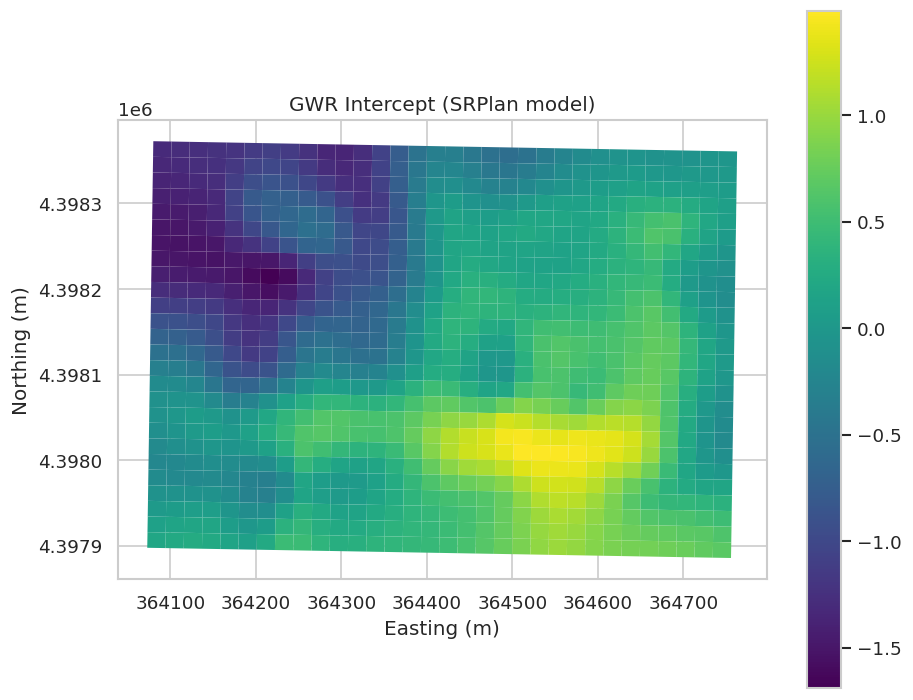

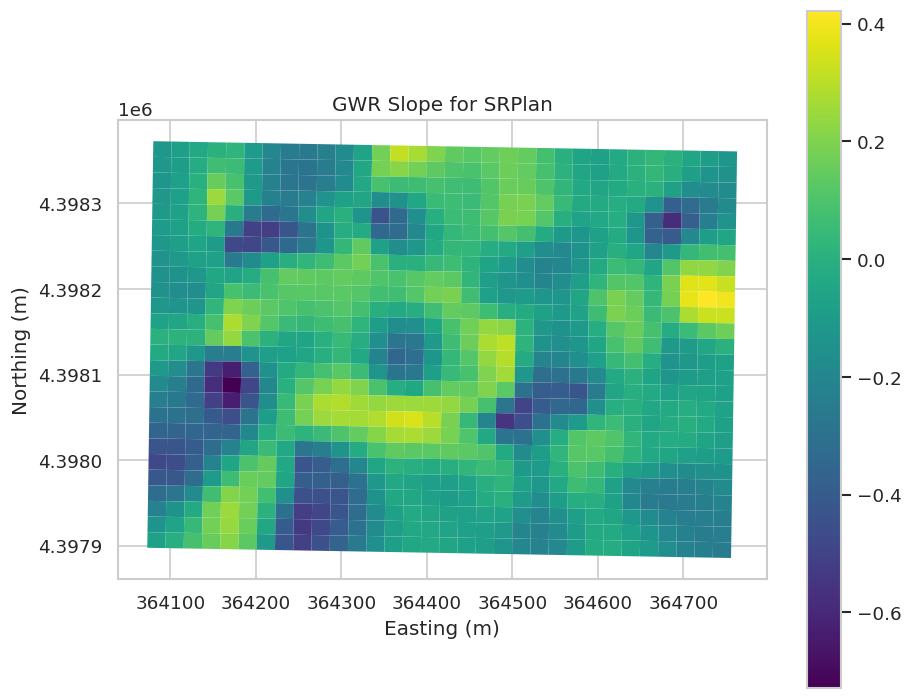

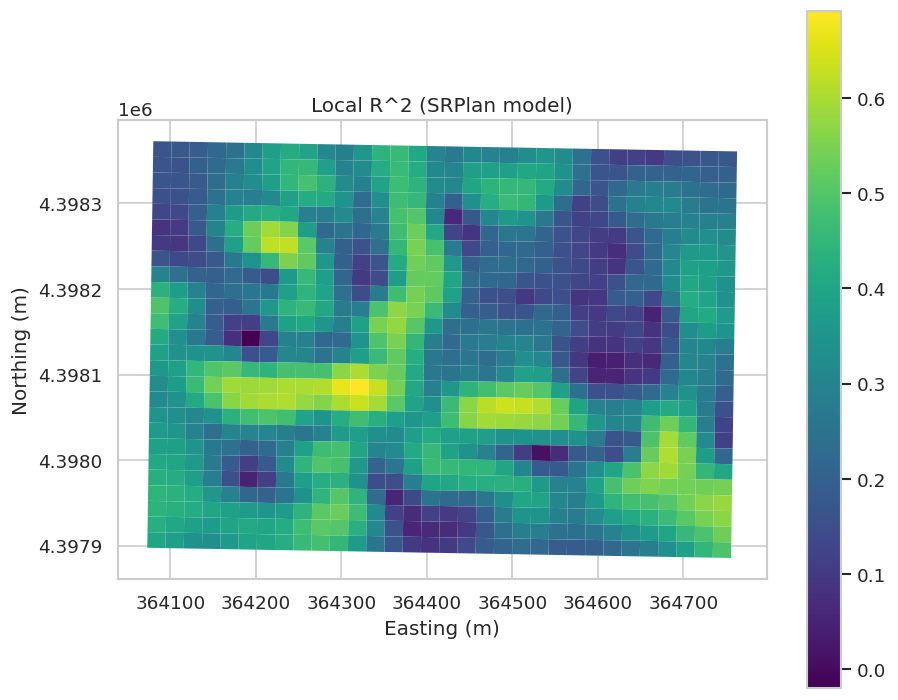

In [ ]:
# Collect results
coef_names = ["Intercept", "SRPlan"]
coef_df = pd.DataFrame(model.params, columns=coef_names)
coef_df["localR2"] = model.localR2

# Merge back to GeoDataFrame (spatial join by index)
res_SRlin = field05.copy()
for col in coef_df.columns:
    res_SRlin[col] = coef_df[col].values

# Plot coefficients and localR2
plot_choropleth(res_SRlin, "Intercept", "GWR Intercept (SRPlan model)")
plot_choropleth(res_SRlin, "SRPlan", "GWR Slope for SRPlan")
plot_choropleth(res_SRlin, "localR2", "Local R^2 (SRPlan model)")

In [ ]:
from mgwr.gwr import GWR, Sel_BW
import pandas as pd, numpy as np

def robust_gwr(gdf, coords, y_col, x_cols, adaptive=True, bw_min=40, tol=1e-8):
    # Design matrices
    X = gdf[x_cols].apply(pd.to_numeric, errors='coerce')
    y = pd.to_numeric(gdf[y_col], errors='coerce')
    mask = (~X.isna().any(axis=1)) & (~y.isna())
    X_arr = X.loc[mask].to_numpy(float)
    y_arr = y.loc[mask].to_numpy(float).reshape(-1, 1)
    coords_arr = coords[mask.values, :]

    # Bandwidth search
    p = X_arr.shape[1]
    selector = Sel_BW(coords_arr, y_arr, X_arr, fixed=not adaptive)
    try:
        bw = selector.search(bw_min=max(bw_min, 2 * p + 1))
    except Exception:
        print("⚠ Adaptive search failed, using fixed bandwidth.")
        selector = Sel_BW(coords_arr, y_arr, X_arr, fixed=True)
        bw = selector.search(bw_min=max(bw_min, 2 * p + 1))
    print(f"Selected bandwidth: {bw}")

    # Fit
    model = GWR(coords_arr, y_arr, X_arr, bw=bw, fixed=not adaptive).fit(tol=tol)
    results = pd.DataFrame(model.params, columns=['Intercept'] + x_cols)
    results['localR2'] = model.localR2
    return model, gdf.loc[mask].join(results)

# --- Run it ---
model, res_cov = robust_gwr(field05, coords_gwr, 'Yield', ['NPlan','SRPlan','ECD','MuKey'])


ImportError: cannot import name 'Sel_BW' from 'mgwr.gwr' (/usr/local/lib/python3.12/dist-packages/mgwr/gwr.py)

In [ ]:
X_design = field05[['NPlan', 'SRPlan', 'ECD', 'MuKey']].copy()
X_design['MuKey'] = pd.to_numeric(X_design['MuKey'], errors='coerce')
# Do NOT add a constant; GWR adds intercept by default (constant=True)

# Coerce to float and drop rows with NaNs
X_numeric = X_design.apply(pd.to_numeric, errors='coerce')
y_series = pd.to_numeric(field05['Yield'], errors='coerce')
mask = (~X_numeric.isna().any(axis=1)) & (~y_series.isna())

X_arr = X_numeric.loc[mask].to_numpy(dtype=float)
y_arr = y_series.loc[mask].to_numpy(dtype=float).reshape(-1, 1)
coords_mask = coords_gwr[mask.values, :]

# Bandwidth selection (adaptive kNN) with safe lower bound
p = X_arr.shape[1]  # number of predictors (no intercept here)
selector = Sel_BW(coords_mask, y_arr, X_arr, fixed=False, spherical=False)
bw = selector.search(bw_min=max(2 * p + 1, 40))
print("Selected bandwidth (adaptive kNN):", bw)

# Fit GWR (intercept added internally)
model = GWR(coords_mask, y_arr, X_arr, bw=bw, fixed=False).fit(tol=1e-8) # Added tolerance for numerical stability
print(model.summary())

# Collect results
col_order = list(X_numeric.columns)  # in order: NPlan, SRPlan, ECD, MuKey
coef_df = pd.DataFrame(model.params, columns=['Intercept'] + col_order)
coef_df['localR2'] = model.localR2

# Merge back to filtered GeoDataFrame
res_cov = field05.loc[mask].copy()
for col in coef_df.columns:
    res_cov[col] = coef_df[col].values

# Plot key outputs
plot_choropleth(res_cov, 'NPlan', 'GWR Slope: NPlan (with covariates, cleaned)')
plot_choropleth(res_cov, 'SRPlan', 'GWR Slope: SRPlan (with covariates, cleaned)')
plot_choropleth(res_cov, 'localR2', 'Local R^2 (with covariates, cleaned)')

LinAlgError: Matrix is singular.

### Geographically Weighted Regression (MGWR)

MGWR allows for different bandwidths for each variable, providing more flexibility in capturing spatially varying relationships.

In [ ]:
# MGWR: Yield ~ SRPlan + NPlan + ECD + MuKey (different bandwidths)

# Prepare data for MGWR (same as GWR with covariates)
X_design_mgwr = field05[['NPlan', 'SRPlan', 'ECD', 'MuKey']].copy()
X_design_mgwr['MuKey'] = pd.to_numeric(X_design_mgwr['MuKey'], errors='coerce')

# Coerce to float and drop rows with NaNs
X_numeric_mgwr = X_design_mgwr.apply(pd.to_numeric, errors='coerce')
y_series_mgwr = pd.to_numeric(field05['Yield'], errors='coerce')
mask_mgwr = (~X_numeric_mgwr.isna().any(axis=1)) & (~y_series_mgwr.isna())

X_arr_mgwr = X_numeric_mgwr.loc[mask_mgwr].to_numpy(dtype=float)
y_arr_mgwr = y_series_mgwr.loc[mask_mgwr].to_numpy(dtype=float).reshape(-1, 1)
coords_mask_mgwr = coords_gwr[mask_mgwr.values, :]

# Bandwidth selection (adaptive kNN for each variable)
selector_mgwr = Sel_BW(coords_mask_mgwr, y_arr_mgwr, X_arr_mgwr, multi=True, fixed=False, spherical=False)
### Causes singu;lar matrix error
bw_mgwr = selector_mgwr.search(multi_bw_min=[40]*(X_arr_mgwr.shape[1] + 1)) # Set a minimum bandwidth for each variable including the intercept
print("Selected bandwidths (adaptive kNN):", bw_mgwr)

# Fit MGWR
model_mgwr = MGWR(coords_mask_mgwr, y_arr_mgwr, X_arr_mgwr, bw=bw_mgwr, fixed=False).fit(tol=1e-8)
print(model_mgwr.summary())

# Collect results
col_order_mgwr = list(X_numeric_mgwr.columns)
coef_df_mgwr = pd.DataFrame(model_mgwr.params, columns=['Intercept'] + col_order_mgwr)
coef_df_mgwr['localR2'] = model_mgwr.localR2

# Merge back to filtered GeoDataFrame
res_mgwr = field05.loc[mask_mgwr].copy()
for col in coef_df_mgwr.columns:
    res_mgwr[col] = coef_df_mgwr[col].values

# Plot key outputs for MGWR
plot_choropleth(res_mgwr, 'NPlan', 'MGWR Slope: NPlan')
plot_choropleth(res_mgwr, 'SRPlan', 'MGWR Slope: SRPlan')
plot_choropleth(res_mgwr, 'ECD', 'MGWR Slope: ECD')
plot_choropleth(res_mgwr, 'MuKey', 'MGWR Slope: MuKey')
plot_choropleth(res_mgwr, 'localR2', 'Local R^2 (MGWR)')

LinAlgError: Matrix is singular.

## Summary

- The GWR procedure estimates spatially varying relationships between Yield and explanatory variables.
- We replicated the R workflow using Python libraries: GeoPandas (data), Statsmodels (OLS), scikit-gstat (variogram), and MGWR (GWR).
- We mapped coefficients and local R^2 for models using SRPlan, NPlan, their interaction, and additional covariates (MuKey, ECD).

Notes:
- Depending on your environment, you may need to install `rtree` for spatial indexing and ensure GEOS/GDAL/PROJ are available.
- If plots render slowly, consider simplifying geometries or plotting centroids for choropleths.
